## Initialization

In [9]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
EXEC_PATH = "C:\opt\ibm\ILOG\CPLEX_Studio2211\cplex\bin\x64_win64\cplex.exe"

In [11]:
model = pyo.ConcreteModel()

## Data

In [12]:
#data
data = pd.read_excel('Dados_DEEC_V2.xlsx', None)
i = len(data['EV_Data']['EV'].tolist())
t = len(data['Building']['t'].tolist())
delta_t = 0.25
n = 0.93
P_ch_max = 5
P_dch_max = 5
C_C = data['Building']['C_C'].tolist()
C_D = data['Building']['C_D'].tolist()
C_IG = data['Building']['C_IG'].tolist()
C_EG = data['Building']['C_EG'].tolist()
P_base = data['Building']['P_base'].tolist()
P_PV = data['Building']['P_PV'].tolist()
L_plus = data['Building']['L_plus'].tolist()
L_minus = data['Building']['L_minus'].tolist()
T_P = data['EV_Data']['T_P'].tolist()
T_arv = data['EV_Data']['T_arv'].tolist()
T_dep = data['EV_Data']['T_dep'].tolist()
E_ev_bat = 30
Soc_arv = data['EV_Data']['Soc_arv'].tolist()
Soc_dep = data['EV_Data']['Soc_dep'].tolist()
Soc_max = 1
Soc_min = 0.2

## Sets

In [13]:
model.I = pyo.RangeSet(i) #index of the vehicles i parked
#out of use due to undetermined number of chargers model.N = pyo.RangeSet(n) #index of the chargers installed (not used at the moment)
model.T = pyo.RangeSet(t) #index of the time periods (min)

## Parameters

In [14]:
model.C_C = pyo.Param(model.T, initialize=lambda model, t: C_C[t-1])
model.C_D = pyo.Param(model.T, initialize=lambda model, t: C_D[t-1])
model.C_IG = pyo.Param(model.T, initialize=lambda model, t: C_IG[t-1])
model.C_EG = pyo.Param(model.T, initialize=lambda model, t: C_EG[t-1])
model.P_base = pyo.Param(model.T, initialize=lambda model, t: P_base[t-1])
model.P_PV = pyo.Param(model.T, initialize=lambda model, t: P_PV[t-1])
model.L_plus = pyo.Param(model.T, initialize=lambda model, t: L_plus[t-1])
model.L_minus = pyo.Param(model.T, initialize=lambda model, t: L_minus[t-1])
model.T_P = pyo.Param(model.I, initialize=lambda model, i:T_P[i-1])
model.T_arv = pyo.Param(model.I, initialize=lambda model, i: T_arv[i-1])
model.T_dep = pyo.Param(model.I, initialize=lambda model, i: T_dep[i-1])
model.Soc_arv = pyo.Param(model.I, initialize=lambda model, i: Soc_arv[i-1])
model.Soc_dep = pyo.Param(model.I, initialize=lambda model, i: Soc_dep[i-1])
model.Soc_max = pyo.Param(initialize=Soc_max)
model.Soc_min = pyo.Param(initialize=Soc_min)
model.E_ev_bat = pyo.Param(initialize=E_ev_bat)
model.n = pyo.Param(initialize=n)
model.P_ch_max = pyo.Param(initialize=P_ch_max)
model.P_dch_max = pyo.Param(initialize=P_dch_max)
model.delta_t = pyo.Param(initialize=delta_t)

## Variables

In [15]:
#Binary variables
model.x = pyo.Var(model.I, model.T, domain=pyo.Binary)
model.y = pyo.Var(model.I, model.T, domain=pyo.Binary)

#Non-binary variables
model.c_e = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.c_ev = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.e_ev = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
#model.e_ev_total_ch = pyo.Var(model.T, domain=pyo.NonNegativeReals)
#model.e_ev_total_dch = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.p_ev_ch = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)
model.p_ev_dch = pyo.Var(model.I, model.T, domain=pyo.NonNegativeReals)

## Constraints

In [16]:
model.constraints = pyo.ConstraintList()

#Constraint 1
for i in model.I:
    for t in range(model.T_arv[i], model.T_dep[i]-1):
    #for t in model.T:
        model.constraints.add(model.x[i,t]+model.y[i,t] <= 1)

#Constraint 2
for i in model.I:
    #for t in range(model.T_arv[i], model.T_dep[i]-1):
    for t in range(2,97):
        model.constraints.add(model.e_ev[i,t] == model.e_ev[i,t-1] + model.delta_t*(model.p_ev_ch[i,t] * model.x[i,t] - model.p_ev_dch[i,t] * model.y[i,t]))

#Constraint 3
for i in model.I:
    model.constraints.add(model.e_ev[i,model.T_dep[i]] >= model.Soc_dep[i] * model.E_ev_bat)

#Constraint 4
for i in model.I:
    model.constraints.add(model.e_ev[i,1] == model.Soc_arv[i] * model.E_ev_bat)

#Constraint 5
for i in model.I:
    for t in model.T:
        model.constraints.add(model.E_ev_bat * model.Soc_min <= model.e_ev[i,t])
        model.constraints.add(model.e_ev[i,t] <= model.Soc_max * model.E_ev_bat)

#Constraint 6
for i in model.I:
    for t in model.T:
        model.constraints.add(0 <= model.p_ev_ch[i,t])
        model.constraints.add(model.p_ev_ch[i,t] <= model.P_ch_max)

#Constraint 7
for i in model.I:
    for t in model.T:
        model.constraints.add(0 <= model.p_ev_dch[i,t])
        model.constraints.add(model.p_ev_dch[i,t] <= model.P_dch_max)

#Constraint 8
for t in model.T:
    model.constraints.add(model.delta_t * ((model.C_IG[t] * (model.L_plus[t] - sum(model.p_ev_dch[i,t] for i in model.I))) + (model.C_EG[t] * (model.L_minus[t] - sum(model.p_ev_ch[i,t] for i in model.I)))) == model.c_e[t])
    #model.constraints.add(model.delta_t * sum(model.p_ev_ch[i,t] * model.x[i,t] for i in model.I) == model.e_ev_total_ch[t])

#Constraint 9
for t in model.T:
    model.constraints.add(sum(model.delta_t * model.C_C[t] * model.p_ev_ch[i,t] for i in model.I)  + sum(model.delta_t * model.C_D[t] * model.p_ev_dch[i,t] for i in model.I) == model.c_ev[t])
    #model.constraints.add(model.delta_t * sum(model.p_ev_dch[i,t] * model.x[i,t] for i in model.I) == model.e_ev_total_dch[t])

#Constraint 9
#for t in model.T:
    #model.constraints.add(model.L_plus[t] == model.delta_t * (model.P_base[t] - model.P_PV[t]))

#Constraint 10
#for t in model.T:
    #model.constraints.add(model.L_minus[t] == model.delta_t * (model.P_PV[t] - model.P_base[t]))

## Objective Function

In [18]:
def rule_obj(mod):
    return sum(model.c_e[t] for t in model.T) - sum(model.c_ev[t] for t in model.T)
    #return sum(mod.C_IG[t] * (mod.L_plus[t] - mod.e_ev_total_dch[t])for t in model.T) - sum(mod.C_EG[t] * (mod.L_minus[t] - mod.e_ev_total_ch[t]) for t in model.T)
model.obj = pyo.Objective(rule = rule_obj, sense = pyo.minimize)

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


## Solver

In [19]:
# Create a solver instance and set executable path
opt = pyo.SolverFactory('gurobi')
# Solve the model
results = opt.solve(model, tee=True)
# Print solution status
print(model.obj())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-20
Read LP format model from file C:\Users\almei\AppData\Local\Temp\tmpy0ujld4r.pyomo.lp
Reading time = 0.03 seconds
x1: 6282 rows, 4972 columns, 10432 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1195G7 @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6282 rows, 4972 columns and 10432 nonzeros
Model fingerprint: 0x6126d416
Model has 950 quadratic constraints
Variable types: 3072 continuous, 1900 integer (1900 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  QMatrix range    [3e-01, 3e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+01]
Presolve removed 5969 rows and 219 columns
Presolve time: 0.01s
Presolved: 6963 rows, 6653 columns,

In [20]:
def plot_energy_levels(e_values, model):
    plt.figure(figsize=(10, 5))
    for i in model.I:
        plt.plot(model.T, e_values[i-1], label=f'Car {i}')
    plt.xlabel('Time step')
    plt.ylabel('Energy [kW]')
    plt.title('Energy Levels of Cars')
    plt.legend()
    plt.grid(True)
    plt.show()

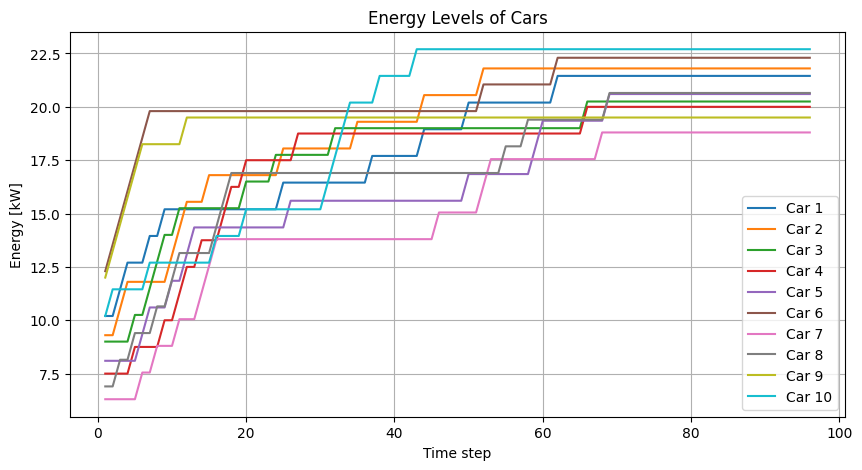

In [21]:
e_values = np.array([[model.e_ev[i, t].value for t in model.T] for i in model.I])
plot_energy_levels(e_values, model)